# Fire or Not?  
<hr style="border:2px solid magenta"> 

**Description** 
* Wildfires are very unpredictable and can occur randomly. Using sattelite images, we can in real time detect a wildfire and warn the proper authorities to mitigate the outgoing damage from wildfires. 

**Objective**
* Create a model that can detect if there is a wildfire in the image with a high f1 score as this is a measure that combines recall and precision of the model. We would want authorities to respond to a real wildfire and false alarm rather than not be alerted that there is a wildfire. It is better to be safe than sorry.  

**Methodology**
* Using a Convolutional Neural Network for wildfire detection. The architecture was designed usign Keras API and was implemented using Python, Tensorflow.  

**Data**
* The dataset was provided by Kaggle: [Wildfire Prediction Dataset (Satellite Images)](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data). It has been divided into three directories: test, train, and validation. The file name are the coordinates of the wildfire location.

### Imports
<hr style="border:2px solid magenta">  

Grabbing the important imports needed

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


Setting the paths to the data

In [3]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')

Creating a function that will extract useful information from each file and return a dataframe of it. With the relative path, latitude and longtitude coordinates, and the class of the image : wildfire or nowildfire. 

In [4]:
def extract_to_df(path):
    filenames = list(path.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))
    coordinates = list(map(lambda x: os.path.split(
        os.path.split(x)[1])[1][:-4], filenames))
    latitudes = [x.split(',')[1] for x in coordinates]
    longitudes = [x.split(',')[0] for x in coordinates]
    
    path = pd.Series(filenames, name = 'Path').astype(str)
    latitude = pd.Series(latitudes, name = 'Latitude').astype(float)
    longitude = pd.Series(longitudes, name = 'Longtitue').astype(float)
    label = pd.Series(labels, name= 'Label').astype(str)
    return pd.concat([path, latitude, longitude, label], axis = 1)


In [5]:
train_df = extract_to_df(train)
test_df = extract_to_df(test)
val_df = extract_to_df(valid)

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True, 
    vertical_flip = True
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)



Extracting images. Starting with 32x32 pixels. Might change it to 64x64 or 224x224 which is another image size standard. 

In [7]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size = (64,64),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size=(64,64),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(64,64),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)


Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


<hr style="border:2px solid magenta">  

Let's do a simple CNN with 1-Convolutional Layer

In [8]:
cnn1 = Sequential()
cnn1.add(Conv2D(filters=32,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(64,64, 3)))
cnn1.add(MaxPooling2D(pool_size=(2,2)))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))

cnn1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=4,
            restore_best_weights=True
        )

In [10]:
results1 = cnn1.fit(train_images,
                    batch_size = 64, 
                    epochs = 50,
                    validation_data = valid_images,
                    callbacks = [early_stop],
                    workers = 6)

Epoch 1/50
237/237 [==============================] - 23s 85ms/step - loss: 0.2862 - accuracy: 0.8815 - val_loss: 0.1841 - val_accuracy: 0.9248
Epoch 2/50
237/237 [==============================] - 21s 86ms/step - loss: 0.2026 - accuracy: 0.9213 - val_loss: 0.1882 - val_accuracy: 0.9257
Epoch 3/50
237/237 [==============================] - 21s 87ms/step - loss: 0.1884 - accuracy: 0.9260 - val_loss: 0.1534 - val_accuracy: 0.9394
Epoch 4/50
237/237 [==============================] - 21s 87ms/step - loss: 0.1781 - accuracy: 0.9307 - val_loss: 0.1988 - val_accuracy: 0.9229
Epoch 5/50
237/237 [==============================] - 21s 86ms/step - loss: 0.1740 - accuracy: 0.9329 - val_loss: 0.1845 - val_accuracy: 0.9294
Epoch 6/50
237/237 [==============================] - 21s 87ms/step - loss: 0.1683 - accuracy: 0.9350 - val_loss: 0.1452 - val_accuracy: 0.9440
Epoch 7/50
237/237 [==============================] - 21s 87ms/step - loss: 0.1647 - accuracy: 0.9368 - val_loss: 0.1430 - val_accuracy:

In [13]:
def plot_graph(results, name = 'None'):

    accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(accuracy))

    temp = name.replace(' ', '_')
    plt.plot(epochs, accuracy, 'bx', label='Training_accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title(label= f'{name} Accuracy vs Epochs')
    plt.legend()
    plt.savefig(f'Logs/64x64/{temp}_accuracy.png')
    plt.figure()

    plt.plot(epochs, loss, 'bx', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(label= f'{name} Loss vs Epochs')
    plt.legend()
    plt.savefig(f'Logs/64x64/{temp}_loss.png')
    plt.figure()

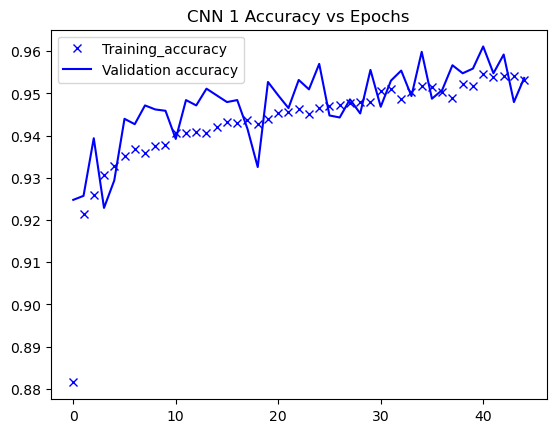

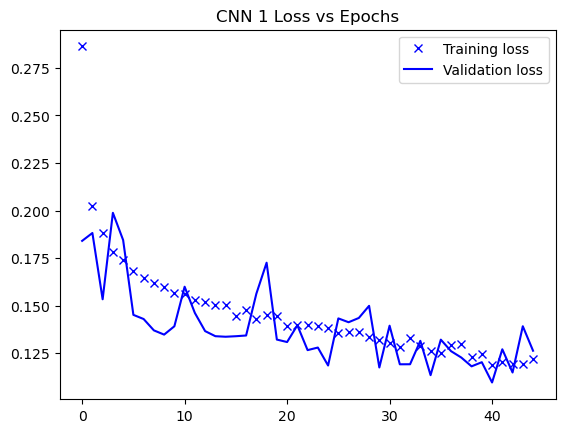

<Figure size 640x480 with 0 Axes>

In [14]:
plot_graph(results1, 'CNN 1')

In [15]:
cnn1.evaluate(test_images)

50/50 [==============================] - 9s 177ms/step - loss: 0.0915 - accuracy: 0.9649


[0.09147898107767105, 0.9649206399917603]

In [16]:
def plot_cm(model, name):
    predictions = (model.predict(test_images) >= 0.5).astype(int)
    cm = confusion_matrix(test_images.labels, predictions)
    temp = name.replace(' ', '_')

    plt.figure(figsize = (6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f'Logs/64x64/{temp}_cm.png')
    plt.show()
    return predictions

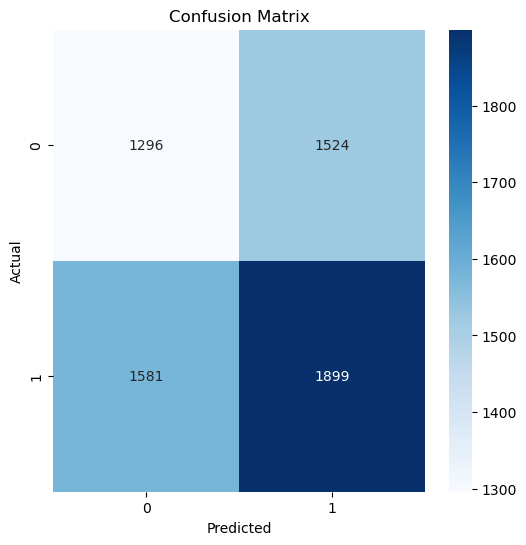

In [17]:
cnn1_predictions = plot_cm(cnn1, 'CNN 1')

In [18]:
print(classification_report(y_true = test_images.labels, y_pred = cnn1_predictions))

              precision    recall  f1-score   support

           0       0.45      0.46      0.45      2820
           1       0.55      0.55      0.55      3480

    accuracy                           0.51      6300
   macro avg       0.50      0.50      0.50      6300
weighted avg       0.51      0.51      0.51      6300



In [19]:
backend.clear_session()


<hr style="border:2px solid magenta">  

Let's increase the complexity by making 4 deep. I am going to add some dropout and batchnormalization to help prevent overfitting

In [20]:
cnn4 = Sequential()

cnn4.add(Conv2D(filters=32,
                kernel_size=3,
                activation='relu',
                input_shape=(64,64, 3)))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=32,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=64,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=128,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Flatten())

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Dense(1, activation='sigmoid'))

cnn4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [21]:
cnn4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        1

In [22]:
results4 = cnn4.fit(train_images,
                    batch_size = 64, 
                    epochs = 50,
                    validation_data = valid_images,
                    callbacks = [early_stop],
                    workers = 6)

Epoch 1/50
237/237 [==============================] - 23s 90ms/step - loss: 0.2403 - accuracy: 0.9043 - val_loss: 1.9047 - val_accuracy: 0.5524
Epoch 2/50
237/237 [==============================] - 22s 90ms/step - loss: 0.1950 - accuracy: 0.9225 - val_loss: 0.9837 - val_accuracy: 0.6344
Epoch 3/50
237/237 [==============================] - 21s 89ms/step - loss: 0.1747 - accuracy: 0.9307 - val_loss: 0.2357 - val_accuracy: 0.9043
Epoch 4/50
237/237 [==============================] - 21s 89ms/step - loss: 0.1641 - accuracy: 0.9370 - val_loss: 0.1641 - val_accuracy: 0.9470
Epoch 5/50
237/237 [==============================] - 21s 88ms/step - loss: 0.1570 - accuracy: 0.9391 - val_loss: 0.1403 - val_accuracy: 0.9508
Epoch 6/50
237/237 [==============================] - 22s 90ms/step - loss: 0.1507 - accuracy: 0.9391 - val_loss: 0.1417 - val_accuracy: 0.9468
Epoch 7/50
237/237 [==============================] - 22s 91ms/step - loss: 0.1469 - accuracy: 0.9418 - val_loss: 0.1622 - val_accuracy:

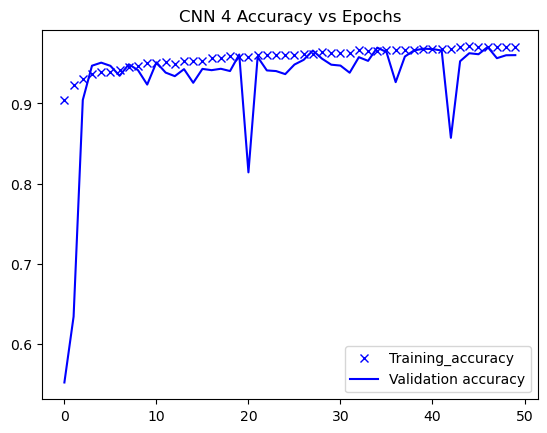

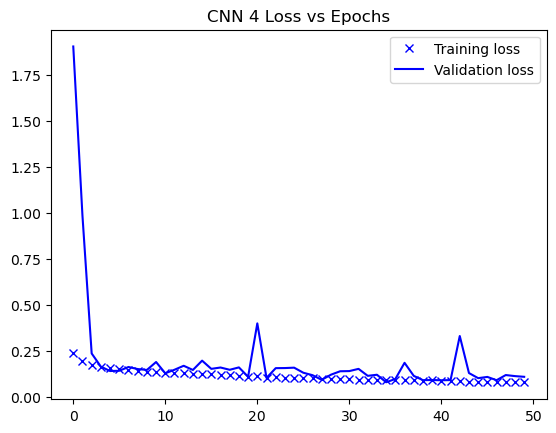

<Figure size 640x480 with 0 Axes>

In [23]:
plot_graph(results4, 'CNN 4')

In [24]:
cnn4.evaluate(test_images)


50/50 [==============================] - 9s 175ms/step - loss: 0.0714 - accuracy: 0.9752


[0.07139422744512558, 0.9752380847930908]

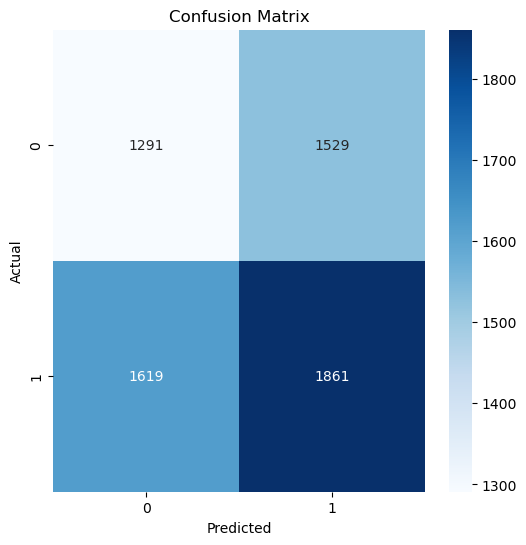

In [25]:
cnn4_predictions = plot_cm(cnn4, 'CNN 4')

In [26]:
print(classification_report(y_true = test_images.labels, y_pred = cnn4_predictions))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45      2820
           1       0.55      0.53      0.54      3480

    accuracy                           0.50      6300
   macro avg       0.50      0.50      0.50      6300
weighted avg       0.50      0.50      0.50      6300



In [ ]:
backend.clear_session()
